## About:
In this notebook, machine-learning based surrogate models of stellar evolution from [Maltsev et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...681A..86M/abstract) are presented. These predict the classical photometric variables bolometric luminosity $\log L/L_\odot$, effective temperature $\log T_\mathrm{eff}/ \mathrm{[K]}$ and surface gravity $\log g/\mathrm{[cm/s^2]}$ of stars evolving from the zero-age-main-sequence (ZAMS) up to the end of core helium burning (CHeB) over a ZAMS mass range of $0.7 \leq M_\mathrm{ZAMS}/M_\odot \leq 300$. The models are trained on the MIST stellar evolution catalog pre-computed by [Choi et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...823..102C/abstract) using the MESA stellar evolution code.

Here, we will explore how to use these models to make forward predictions of

- stellar evolution tracks and
- isochrones

in the Hertzsprung-Russell (HR) and Kiel diagrams. The advantage of the surrogate models are that
- they are fast-to-evaluate and
- they can make predictions over a quasi-continuous parameter space in ZAMS mass and age.

## Packages and dependencies

In [1]:
import numpy as np
from tensorflow import keras 
#from tensorflow.keras.models import load_model
import tensorflow 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from datetime import datetime

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.0.


In [3]:
print(tensorflow.__version__)

2.5.0


In [4]:
# python script containing all relevant methods
from stellar_evolution_emulator import *

## Loading the fitted ML models 
There are in total four models needed here:
- the *k*-nearest neighbors model (*knn_model*),
- the feedforward neural network (*ffNN*) model and
- the two Gaussian Process Regression models (*gpr_modelTE*, *gpr_modelTA*)

In [5]:
ffNN = keras.models.load_model("models/ffNN")
#ffNN = load_model("models/step2_rh0_80k")
knn_model = pickle.load(open("models/knn_model.pkl", "rb"))

gpr_modelTE = pickle.load(open("models/gpr_modelTE.pkl", "rb"))
gpr_modelTA = pickle.load(open("models/gpr_modelTA.pkl", "rb"))

## Table of Contents:
   1. **Predicting stellar evolution tracks** (ZAMS - end of CHeB):
       - Single track at fixed ZAMS mass
       - Multiple tracks over a range of ZAMS masses
       - Stellar evolution re-parametrization using $s$
       - Scalability
<br>  
<br>
   2. **Predicting isochrones**
       - Stellar ages at ZAMS and at the end of CHeB
       - Stellar observables at fixed age and ZAMS mass
       - Isochrones in the HR diagram

## 1. Predicting stellar evolution tracks (ZAMS - end of CHeB) 
For predicting stellar evolution tracks (without the age information), only the *ffNN* model is needed. The *ffNN* model predicts the classical photometric observables  $\log L/L_\odot$, effective temperature $\log T_\mathrm{eff}/ \mathrm{[K]}$ and surface gravity $\log g/\mathrm{[cm/s^2]}$ as a function of the timescale-adapted evolutionary coordinate $s$ and (log-scaled) ZAMS mass: 

<br>


$\log L/L_\odot, \log T_\mathrm{eff}/ \mathrm{[K]}, \log g/\mathrm{[cm/s^2]} = \mathrm{ffNN}(s, \log M_\mathrm{ZAMS}/M_\odot)$.

<br>


When $s=0$, the star is at the ZAMS. When $s=1$, the star has reached the end of CHeB. Here, we will uniformly sample $s$ in order to predict stellar tracks.

### Single track at fixed ZAMS mass:
Here, you can supply any $M_\mathrm{ZAMS}$ value of interest, in solar mass units $M_\odot$. The algorithm will return the predictions of the classical photometric variables for a star of this ZAMS, while it evolves from ZAMS up to the end of CHeB.

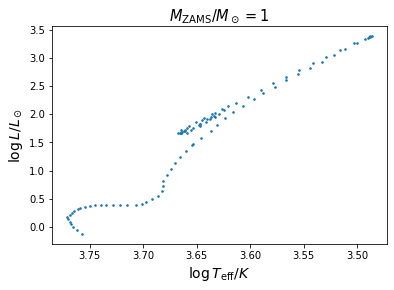

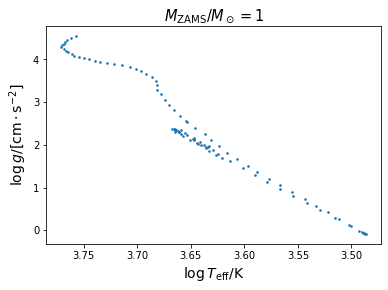

In [4]:
ds = 0.01
s_sampling = np.arange(0, 1+ds, ds)
M_ZAMS = 1

logL, logTeff, logg = HR_and_Kiel_track(M_ZAMS, s_sampling, ffNN)
plot_HR(logL, logTeff, M_ZAMS)
plot_Kiel(logg, logTeff, M_ZAMS)

### Multiple tracks over a range of ZAMS masses:
Define a $M_\mathrm{ZAMS}/M_\odot$- range over which you would like to have stellar evolution tracks from ZAMS up to the end of CHeB predicted. You can choose any values $M_\mathrm{ZAMS}/M_\odot \in (0.7, 300)$.

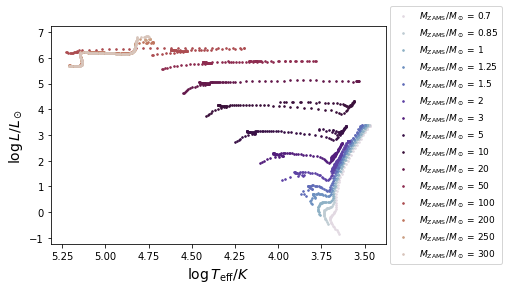

In [5]:
M_ZAMS_range = [0.7, 0.85, 1, 1.25, 1.5, 2, 3, 5, 10, 20, 50, 100, 200, 250, 300]

ds = 0.01
s_sampling = np.arange(0, 1+ds, ds)

plt.figure()
plt.xlabel(r"$\log T_\mathrm{eff} / K$", fontsize = 14)
plt.ylabel(r"$\log L / L_\odot$", fontsize = 14)
plt.gca().invert_xaxis()

for i in range(0, len(M_ZAMS_range)):
    logL, logTeff, logg = HR_and_Kiel_track(M_ZAMS_range[i], s_sampling, ffNN)
    plt.scatter(logTeff, logL, s = 2.5, color = color_map_color(i/len(M_ZAMS_range), 'twilight', 0, 1), label = r'$M_\mathrm{ZAMS}/M_\odot$ = '+str(M_ZAMS_range[i]))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 9)
#plt.savefig("tracksHR.png", dpi = 200, bbox_inches = "tight")
plt.show()   

### Stellar evolution re-parametrization using $s$
In the above, the timescale-adapted evolutionary coordinate $s$ introduced in [Maltsev et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...681A..86M/abstract) has been used to parametrize the evolution of stars. The reason why it is favorable to use $s$ instead of stellar age $t$ is that $s$ addresses the multi-scale problem of having variability across orders of magnitude separated temporal scales. 

Stellar age $\tau_i = \sum_{j=1}^i \delta t_j$  after computation step $i$ is a monotonically increasing function which grows cumulatively at an adaptive step size $\delta t_j$ after each step $j=1, \dots, i$ of numerical time integration of the differential equations describing stellar structure and evolution. The age proxy variable $s_i = \sum_{j=1}^i \delta s_j$ is constructed analogously, but here $\delta s_j$ is the increment in the star's Euclidean displacement in a diagram spanned by a set of its physical variables, obtained after the numerical time integration step $j=1, \dots, i$. It is calculated as follows:
 
 
$    \delta \tilde{s}_j = \sqrt{ \left| \Delta_\mathrm{j,j-1}\log \frac{L}{\mathrm{L_\odot}} \right|^2+ \left| \Delta_\mathrm{j,j-1} \log \frac{T_\mathrm{eff}}{\mathrm{K}} \right|^2+ \left| \Delta_\mathrm{j,j-1} \log \frac{\rho_{c}}{[\mathrm{g} \cdot \mathrm{cm}^{-3}]} \right|^2 }$

where $\Delta_\mathrm{j,j-1} X = X_j - X_\mathrm{j-1}$ and $\rho_c$ is the core density.

After a normalization procedure $\tilde{s} \rightarrow s$, the unified range is $s \in (0,1)$ for each star. Thus to produce predictions of stellar variables for any star, we only need to sample $s$ from 0 to 1 and do not need to use the above formula. 

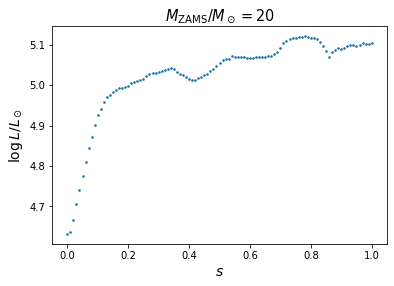

In [6]:
ds = 0.01
s_sampling = np.arange(0, 1+ds, ds)
M_ZAMS = 20

logL, logTeff, logg = HR_and_Kiel_track(M_ZAMS, s_sampling, ffNN)

plt.figure()
plt.scatter(s_sampling, logL, s = 2.5)
plt.xlabel(r"$s$", fontsize = 14)
plt.ylabel(r"$\log L / L_\odot$", fontsize = 14)
plt.title(r"$M_\mathrm{ZAMS}/M_\odot=$"+str(M_ZAMS), fontsize = 14.5)
plt.show()

### Scalability
The main advantage of using machine-learning based surrogate models over classical interpolation methods is the speed-up. Here, we quantify how fast prediction-making is ($t$ in units of seconds $s$) as a function of number of point forecasts $n$ to make. These will vary depending on the computer architecture you use. On a 4-core CPU, casting $n = 10^6$ point predictions should take roughly $t=40 \,s$.

In [7]:
times = pd.DataFrame(columns = ["n", 't'])

# defining a random input array in the (s, log M_ZAMS/Msun) space
def random_array(n):
    df_scalingtest = pd.DataFrame(columns = ['s', 'm'])
    df_scalingtest['m'] = np.random.uniform(np.log10(0.7), np.log10(300), n)
    df_scalingtest['s'] = np.random.uniform(0, 1, n)    
    return df_scalingtest

In [8]:
n = n1 = 10000 
df_scalingtest = random_array(n)
StartTime = datetime.now()
ffNN.predict(df_scalingtest.values)
t = t1 = datetime.now()- StartTime
print(t)

n = n2 = 100000
df_scalingtest = random_array(n)
StartTime = datetime.now()
ffNN.predict(df_scalingtest.values)
t = t2 = datetime.now()- StartTime
print(t)

n = n3 = 1000000
df_scalingtest = random_array(n)
StartTime = datetime.now()
ffNN.predict(df_scalingtest.values)
t = t3 = datetime.now()- StartTime
print(t)

0:00:00.963679
0:00:08.319998
0:01:20.754853


In [14]:
times.loc[0,:] = n1, t1
times.loc[1,:] = n2, t2
times.loc[2,:] = n3, t3
times

,n,t
0,10000,0:00:00.447528
1,100000,0:00:05.135021
2,1000000,0:00:44.682552


## 2. Isochrones in HR and Kiel diagrams  

In order to predict isochrones in the HR and Kiel diagrams, all the four predictive models are needed. These are used in a two-step interpolation scheme:

1. The *k*-nearest neighbors model (*knn_model*) predicts $s$, the timescale-adapted evolutionary coordinate, as a function of (log-scaled) ZAMS mass and stellar age $\tau$:

<br>

$s = \mathrm{KNN}(\tilde{\tau}, \log M_\mathrm{ZAMS}/M_\odot)$.

<br>

As its input, the *knn_model* requires a scaled age variable $\tilde{\tau} \in (0, 1)$ for each $M_\mathrm{ZAMS}$:

$\tilde{\tau}(M_\mathrm{ZAMS}) = \frac{\log \tau(M_\mathrm{ZAMS}) - \log \tau_\mathrm{ZAMS}(M_\mathrm{ZAMS}) }{\log \tau_\mathrm{TACHeB}(M_\mathrm{ZAMS})-\log \tau_\mathrm{ZAMS}(M_\mathrm{ZAMS})}$.

For the scaling $\tau \rightarrow \tilde{\tau}$, the stellar ages at ZAMS ($\tau_\mathrm{ZAMS}$) and at the end of CHeB ($\tau_\mathrm{TACHeB}$) need to be known. These are predicted (in log-scale) by the two Gaussian Process Regression models (*gpr_modelTE*, *gpr_modelTA*) as a function of $M_\mathrm{ZAMS}$. For the age values, the same time counting convention as in the MIST catalog is adopted.


2. The *ffNN* model predicts the classical photometric observables  $\log L/L_\odot$, effective temperature $\log T_\mathrm{eff}/ \mathrm{[K]}$ and surface gravity $\log g/\mathrm{[cm/s^2]}$ as a function of $s$ and (log-scaled) ZAMS mass. This means that together with the mass, the *ffNN* model requires $s$ as input, which is supplied by the *knn_model*. 

### Stellar ages at ZAMS and at the end of CHeB:
Let's first see how to obatin the stellar ages $\tau_\mathrm{ZAMS}$ and $\tau_\mathrm{CHeB}$ using the GPR models.
All the age predictions are in units of years $\mathrm{[yr]}$ and casted on a $\log$-scale.

In [13]:
# ZAMS and TACHeB age prediction in units of years and with log10 scaling, for a given ZAMS mass
M_ZAMS = 2.
log10_ZAMS = gpr_modelTA.predict(np.log10(M_ZAMS).reshape(1,-1))
log10_TACHeB = gpr_modelTE.predict(np.log10(M_ZAMS).reshape(1,-1))
print('stellar age at ZAMS (log-scale): ', log10_ZAMS) 
print('stellar age at the end of CHeB (log-scale:) ', log10_TACHeB)

stellar age at ZAMS (log-scale):  [6.95608359]
stellar age at the end of CHeB (log-scale:)  [9.12074163]


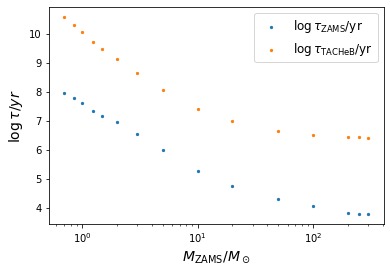

In [14]:
# ZAMS and TACHeB age predictions for stars of different ZAMS masses
M_ZAMS_range = [0.7, 0.85, 1, 1.25, 1.5, 2, 3, 5, 10, 20, 50, 100, 200, 250, 300]

log_zams_vals = gpr_modelTA.predict(np.log10(M_ZAMS_range).reshape(-1,1))
log_tacheb_vals = gpr_modelTE.predict(np.log10(M_ZAMS_range).reshape(-1,1))

plt.figure()
plt.xscale('log')
plt.xlabel(r"$M_\mathrm{ZAMS}/M_\odot$", fontsize = 14)
plt.ylabel(r"$\log \tau / yr$", fontsize = 14)
plt.scatter(M_ZAMS_range, log_zams_vals, s = 5, label = r"$\log \tau_\mathrm{ZAMS}/\mathrm{yr}$")
plt.scatter(M_ZAMS_range, log_tacheb_vals, s = 5, label = r"$\log \tau_\mathrm{TACHeB}/\mathrm{yr}$")
plt.legend(loc = 'upper right', fontsize = 12)
plt.show() 

### Stellar observables at fixed age and ZAMS mass:
Now let's see how to make point predictions of the classical photometric variables $\log L/L_\odot$, $\log T_\mathrm{eff}/ \mathrm{[K]}$ and $\log g/\mathrm{[cm/s^2]}$ for any given stellar age $\tau$ and ZAMS mass $M_\mathrm{ZAMS}$. The valid ranges are $M_\mathrm{ZAMS}/M_\odot \in (0.7, 300)$ and $\tau \in (\tau_\mathrm{ZAMS}, \tau_\mathrm{TACHeB})$. You may find out these $M_\mathrm{ZAMS}$-dependent boundary values in age in the step above. 

In [6]:
M_ZAMS = 10 # in solar-mass units, linear scale
test_age = 10**7 # in years, linear scale
output_ffNN = observables_fixed_tau_MZAMS(test_age, np.log10(M_ZAMS), gpr_modelTA, gpr_modelTE, knn_model, ffNN)
log_L_val, log_Teff_val, log_g_val = output_ffNN[0,:] 
# the outputs are bolometric luminosity, effective temperature, surface gravity (all in log-scale)
print('log_L/Lsun:', log_L_val)

log_L/Lsun: 3.855856


### Isochrones in the HR diagram:
Finally, we have all we need for plotting isochrones that show stars of the same age in the HR diagram. Here, we assume a starburst and follow the convention that two stars are of the same age if the same amount of time has passed for both stars past the ZAMS. 

The procedure is as follows: First, a ZAMS mass range needs to be defined over which isochrones will be computed. Second, the values of the isochrones need to be chosen. The method *isochrone_computation()* returns the dictionary *iso_dict*. Its entries are the values of the isochrones. For each isochrone entry, *iso_dict* returns a dataframe that contains the three photometric observables of stars that are of this age.

From the user perspective, there are thus two degrees of freedom here:
1. the choice of the isochrones (which stellar ages?)
2. the resolution of the isochrone plot (which ZAMS masses?)

The higher the desired resolution (in particular over fast-timescale evolutionary phases such as the Hertzsprung gap), the greater the ZAMS mass sampling density needs to be, and the longer it takes to produce the isochrones.

In [16]:
# define age labels for the isochrone plots you might want to use
labeling = {}
labeling[1e+6] = "1 Myr"
labeling[2e+6] = "2 Myr"
labeling[5e+6] = "5 Myr"
labeling[1e+7] = "10 Myr"
labeling[2e+7] = "20 Myr"
labeling[5e+7] = "50 Myr"
labeling[1e+8] = "100 Myr"
labeling[2e+8] = "200 Myr"
labeling[5e+8] = "500 Myr"
labeling[1e+9] = "1 Gyr"
labeling[2e+9] = "2 Gyr"
labeling[5e+9] = "5 Gyr"
labeling[1e+10] = "10 Gyr"

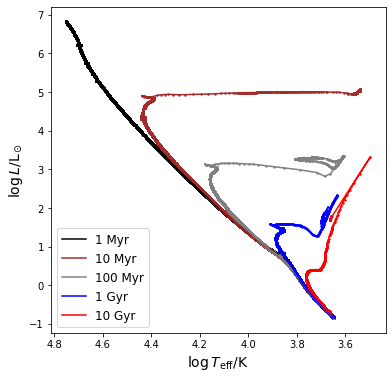

In [20]:
# log-linear ZAMS mass sampling density
delta_logMini = 0.00005
log_Mini = np.arange(np.log10(0.7), np.log10(300.), delta_logMini )

# choice of isochrone values (time passed after the ZAMS) 
iso_values = [1e+6, 1e+7, 1e+8, 1e+9, 1e+10]
iso_colors = ['black', 'brown', 'grey', 'blue', 'red']

# computation of isochrones
iso_dict, all_columns_df = isochrone_computation(log_Mini, iso_values, gpr_modelTA, gpr_modelTE, knn_model, ffNN)

# plots of isochrones
plt.figure(figsize = (6,6))

i = 0
for item in list(iso_dict.keys()):
    
    # get isochrones, for each age
    df = iso_dict[item]
    l = labeling[item]    
    
    plt.scatter(df.logT, df.logL, s = 2, color = iso_colors[i] )
    plt.plot(df.logT, df.logL, label = l, color = iso_colors[i] )
    i = i+1

plt.gca().invert_xaxis()
plt.xlabel("$\log T_\mathrm{eff}/\mathrm{K}$", fontsize = 14)
plt.ylabel("$\log L/\mathrm{L_\odot}$", fontsize = 14)
plt.legend(loc = "lower left", fontsize = 12)
plt.show()

In [57]:
all_columns_df

,logL,logTeff,logg,logMini,isochrone,test_age,t_scaled
0,-0.845899,3.647825,4.676198,-0.154902,6.0,7.949695,0.001856
1,-0.845650,3.647855,4.676138,-0.154852,6.0,7.949570,0.001857
2,-0.845404,3.647885,4.676077,-0.154802,6.0,7.949445,0.001857
3,-0.845153,3.647915,4.676013,-0.154752,6.0,7.949321,0.001858
4,-0.844911,3.647945,4.675959,-0.154702,6.0,7.949197,0.001858
...,...,...,...,...,...,...,...
112588,1.711106,3.662013,2.334365,0.015948,10.0,10.001625,0.999666
112589,1.718559,3.661264,2.324854,0.015998,10.0,10.001624,0.999738
112590,1.737348,3.659362,2.300764,0.016048,10.0,10.001624,0.999810
112591,1.798079,3.653430,2.224420,0.016098,10.0,10.001623,0.999883
